In [1]:
pip -q install transformers datasets    

In [2]:
!nvidia-smi

Sat Jan 29 17:10:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# load tensorboard extension
%load_ext tensorboard

# Patronizing and Condescending Language Detection

##Task 2

## Prepare Dataset

In [4]:
import pandas as pd
import numpy as np

In [5]:
!wget https://gist.githubusercontent.com/Sirwe-Saeedi/ea22d87102a08df69aea188e53fa16af/raw/8a4106077c4ce731044bc8546ad795c42cfe68d0/PCL_task2_Training_Set.tsv

--2022-01-29 17:10:02--  https://gist.githubusercontent.com/Sirwe-Saeedi/ea22d87102a08df69aea188e53fa16af/raw/8a4106077c4ce731044bc8546ad795c42cfe68d0/PCL_task2_Training_Set.tsv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1342370 (1.3M) [text/plain]
Saving to: ‘PCL_task2_Training_Set.tsv.1’

PCL_task2_Training_ 100%[===================>]   1.28M  --.-KB/s    in 0.03s   

2022-01-29 17:10:03 (39.8 MB/s) - ‘PCL_task2_Training_Set.tsv.1’ saved [1342370/1342370]



In [6]:
#Skip the disclaimer at the beginning of file
df_categories = pd.read_csv('./PCL_task2_Training_Set.tsv', sep='\t', skiprows=4, header = None)
df_categories.columns = ['par_id','art_id',	'text', 'keyword',	'country_code', 'span_start', 'span_finish', 'span_text', 'pcl_category', 'number_of_annotators']
#  number_of_annotators = 'number_of_annotators_agreeing_in_that_label'
#df_pcl.drop('index', axis = 1, inplace=True)
df_categories

,par_id,art_id,text,keyword,country_code,span_start,span_finish,span_text,pcl_category,number_of_annotators
0,4046,@@14767805,We also know that they can benefit by receivin...,hopeless,us,201,236,put their situation in perspective,Authority_voice,2
1,4046,@@14767805,We also know that they can benefit by receivin...,hopeless,us,240,274,help them communicate with others,Unbalanced_power_relations,2
2,4046,@@14767805,We also know that they can benefit by receivin...,hopeless,us,274,300,who could provide support,Unbalanced_power_relations,1
3,4046,@@14767805,We also know that they can benefit by receivin...,hopeless,us,384,434,plan for their needs and the needs of their child,Authority_voice,2
4,4046,@@14767805,We also know that they can benefit by receivin...,hopeless,us,0,35,We also know that they can benefit,Unbalanced_power_relations,1
...,...,...,...,...,...,...,...,...,...,...
2755,10070,@@15573661,Fern ? ndez was a well-known philanthropist wh...,disabled,ng,0,210,Fern ? ndez was a well-known philanthropist wh...,Unbalanced_power_relations,1
2756,6484,@@2559173,"Touched much by their plight , Commanding Offi...",homeless,lk,0,29,Touched much by their plight,Compassion,1
2757,6484,@@2559173,"Touched much by their plight , Commanding Offi...",homeless,lk,31,315,Commanding Officer and all ranks of the 7 Sri ...,Unbalanced_power_relations,1
2758,6249,@@1947926,She reiterated her ministry 's commitment to p...,women,gh,153,205,gave a strong indication of hope for Ghanaian ...,Unbalanced_power_relations,1


In [7]:
df_categories['number_of_annotators']

0       2
1       2
2       1
3       2
4       1
       ..
2755    1
2756    1
2757    1
2758    1
2759    1
Name: number_of_annotators, Length: 2760, dtype: int64

In [8]:
df_categories['number_of_annotators'].value_counts()

2    1401
1    1359
Name: number_of_annotators, dtype: int64

In [9]:
print(f"category_label NaN values : {df_categories['pcl_category'].isnull().sum()}")
print(f"span_tetx NaN values : {df_categories['span_text'].isnull().sum()}")

category_label NaN values : 0
span_tetx NaN values : 0


In [10]:
# df_categories = df_categories[df_categories['pcl_category'].notna()]
# df_categories = df_categories[df_categories['span_text'].notna()]

In [11]:
# print(f"category_label NaN values : {df_categories['pcl_category'].isnull().sum()}")
# print(f"span_tetx NaN values : {df_categories['span_text'].isnull().sum()}")

In [12]:
a = df_categories['pcl_category'].astype('category')
df_categories['labels'] = a.cat.codes

In [13]:
a

0                  Authority_voice
1       Unbalanced_power_relations
2       Unbalanced_power_relations
3                  Authority_voice
4       Unbalanced_power_relations
                   ...            
2755    Unbalanced_power_relations
2756                    Compassion
2757    Unbalanced_power_relations
2758    Unbalanced_power_relations
2759               Authority_voice
Name: pcl_category, Length: 2760, dtype: category
Categories (7, object): ['Authority_voice', 'Compassion', 'Metaphors', 'Presupposition',
                         'Shallow_solution', 'The_poorer_the_merrier', 'Unbalanced_power_relations']

In [14]:
df_categories['labels']

0       0
1       6
2       6
3       0
4       6
       ..
2755    6
2756    1
2757    6
2758    6
2759    0
Name: labels, Length: 2760, dtype: int8

In [15]:
df_categories['labels'].value_counts()

6    968
1    682
3    296
0    285
2    250
4    227
5     52
Name: labels, dtype: int64

In [16]:
df_categories['labels'].unique()

array([0, 6, 4, 3, 1, 2, 5], dtype=int8)

In [17]:
len(df_categories)

2760

## Multi-label Classification


In [18]:
import os
#os.environ['WANDB_PROJECT'] = 'pcl-binary'

In [19]:
import torch
from tqdm.notebook import tqdm

from transformers import RobertaTokenizer, BertTokenizer
from torch.utils.data import TensorDataset

from transformers import RobertaForSequenceClassification, BertForSequenceClassification

import seaborn as sns

In [20]:
len(df_categories)

2760

In [21]:
df_categories.isnull().sum()

par_id                  0
art_id                  0
text                    0
keyword                 0
country_code            0
span_start              0
span_finish             0
span_text               0
pcl_category            0
number_of_annotators    0
labels                  0
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


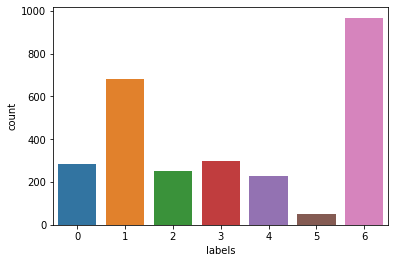

In [22]:
sns.countplot(df_categories['labels']);

## Training using Huggingface API

In [23]:
df_categories_selected = df_categories
def combine_features(row):
  return '<s>'.join(row.drop(['text','keyword','span_start','span_finish','pcl_category','labels'],axis=0).apply(str).values)
df_categories_selected['combined_features'] = df_categories_selected.apply(combine_features, axis = 1)
#['par_id','art_id',	'text', 'keyword',	'country_code', 'span_start', 'span_finish', 'span_text', 'pcl_category', 'number_of_annotators']

In [24]:
df_categories['span_text'].duplicated().value_counts()

False    2547
True      213
Name: span_text, dtype: int64

In [25]:
valid_size = 279
duplicate = df_categories_selected[df_categories['span_text'].duplicated()]
none_duplicate = df_categories_selected.drop(duplicate.index, axis=0)
df_categories_valid = none_duplicate.sample(valid_size, random_state = 42)
df_categories_train = df_categories_selected.drop(df_categories_valid.index, axis=0)
df_categories_train

,par_id,art_id,text,keyword,country_code,span_start,span_finish,span_text,pcl_category,number_of_annotators,labels,combined_features
0,4046,@@14767805,We also know that they can benefit by receivin...,hopeless,us,201,236,put their situation in perspective,Authority_voice,2,0,4046<s>@@14767805<s>us<s>put their situation i...
1,4046,@@14767805,We also know that they can benefit by receivin...,hopeless,us,240,274,help them communicate with others,Unbalanced_power_relations,2,6,4046<s>@@14767805<s>us<s>help them communicate...
2,4046,@@14767805,We also know that they can benefit by receivin...,hopeless,us,274,300,who could provide support,Unbalanced_power_relations,1,6,4046<s>@@14767805<s>us<s>who could provide sup...
3,4046,@@14767805,We also know that they can benefit by receivin...,hopeless,us,384,434,plan for their needs and the needs of their child,Authority_voice,2,0,4046<s>@@14767805<s>us<s>plan for their needs ...
4,4046,@@14767805,We also know that they can benefit by receivin...,hopeless,us,0,35,We also know that they can benefit,Unbalanced_power_relations,1,6,4046<s>@@14767805<s>us<s>We also know that the...
...,...,...,...,...,...,...,...,...,...,...,...,...
2755,10070,@@15573661,Fern ? ndez was a well-known philanthropist wh...,disabled,ng,0,210,Fern ? ndez was a well-known philanthropist wh...,Unbalanced_power_relations,1,6,10070<s>@@15573661<s>ng<s>Fern ? ndez was a we...
2756,6484,@@2559173,"Touched much by their plight , Commanding Offi...",homeless,lk,0,29,Touched much by their plight,Compassion,1,1,6484<s>@@2559173<s>lk<s>Touched much by their ...
2757,6484,@@2559173,"Touched much by their plight , Commanding Offi...",homeless,lk,31,315,Commanding Officer and all ranks of the 7 Sri ...,Unbalanced_power_relations,1,6,6484<s>@@2559173<s>lk<s>Commanding Officer and...
2758,6249,@@1947926,She reiterated her ministry 's commitment to p...,women,gh,153,205,gave a strong indication of hope for Ghanaian ...,Unbalanced_power_relations,1,6,6249<s>@@1947926<s>gh<s>gave a strong indicati...


In [26]:
df_categories_valid

,par_id,art_id,text,keyword,country_code,span_start,span_finish,span_text,pcl_category,number_of_annotators,labels,combined_features
62,5996,@@2822899,Real poverty of Britain : Shocking images of U...,poor-families,gb,135,198,glimpse into the harrowing day-to-day for poor...,Compassion,1,1,5996<s>@@2822899<s>gb<s>glimpse into the harro...
213,10468,@@16753236,""" Anja Ringgren Loven I ca n't find a word to ...",hopeless,in,79,187,May God almighty keep blessing you and always ...,Unbalanced_power_relations,1,6,10468<s>@@16753236<s>in<s>May God almighty kee...
2497,6910,@@19027470,World Refugee Day is marked on June 20 every y...,refugee,gh,0,18,World Refugee Day,Shallow_solution,2,4,6910<s>@@19027470<s>gh<s>World Refugee Day<s>2
256,7153,@@60096684,"He stayed true to his promise , and at the ope...",homeless,pk,75,153,he brought a lot of homeless from the park to ...,Unbalanced_power_relations,2,6,7153<s>@@60096684<s>pk<s>he brought a lot of h...
2567,7735,@@4940628,King Wenceslas is probably standing on an elev...,hopeless,lk,339,389,The benevolent King is deeply moved by this sight,Unbalanced_power_relations,2,6,7735<s>@@4940628<s>lk<s>The benevolent King is...
...,...,...,...,...,...,...,...,...,...,...,...,...
34,773,@@1759840,Sheepherding in America has always been an imm...,immigrant,us,62,122,"too dirty , too cold and too lonely for anyone...",Compassion,2,1,"773<s>@@1759840<s>us<s>too dirty , too cold an..."
2082,7888,@@50041353,Kate has also worked to help Liverpool 's home...,homeless,gb,61,87,by handing out gift boxes,Shallow_solution,2,4,7888<s>@@50041353<s>gb<s>by handing out gift b...
908,1510,@@23162563,""" Someone has to be there to care , "" he says ...",vulnerable,ie,2,34,Someone has to be there to care,Compassion,2,1,1510<s>@@23162563<s>ie<s>Someone has to be the...
2120,7095,@@1737715,Battling homelessness through fashion is the b...,homeless,us,0,185,Battling homelessness through fashion is the b...,Unbalanced_power_relations,2,6,7095<s>@@1737715<s>us<s>Battling homelessness ...


In [27]:
from datasets import Dataset
raw_datasets_valid = Dataset.from_pandas(df_categories_valid[['combined_features','labels']])
raw_datasets_train = Dataset.from_pandas(df_categories_train[['combined_features','labels']])
raw_datasets_train, raw_datasets_valid

(Dataset({
     features: ['combined_features', 'labels', '__index_level_0__'],
     num_rows: 2481
 }), Dataset({
     features: ['combined_features', 'labels', '__index_level_0__'],
     num_rows: 279
 }))

Because the labels are imbalanced, we split the data set in a stratified fashion, using this as the class labels.

In [28]:
# FIXME: Ali - Idea: Try zero shot, few shot, fine-tuning with GPT-3
from transformers import AutoTokenizer
model_name = 'roberta-large'
# model_name = 'bert-base-uncased'
# model_name = 'roberta-large-openai-detector' #FIXME: Ali - Idea: Try other larger models
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [29]:
def tokenize_function(examples):
    return tokenizer(examples["combined_features"], padding="max_length", truncation=True)

tokenized_datasets_train = raw_datasets_train.map(tokenize_function, batched=True)
tokenized_datasets_valid = raw_datasets_valid.map(tokenize_function, batched=True)
tokenized_datasets_train

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Dataset({
    features: ['combined_features', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 2481
})

In [30]:
# small_dataset_size = 10
# full_train_dataset = tokenized_datasets_train.shuffle(seed=42).select(range(small_dataset_size))
# full_eval_dataset = tokenized_datasets_valid.shuffle(seed=42).select(range(small_dataset_size))
full_train_dataset = tokenized_datasets_train
full_eval_dataset = tokenized_datasets_valid

In [31]:
# model_bert = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
# model_bert

In [32]:
# model_bert()

In [33]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=7)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classi

In [34]:
from datasets import load_metric, list_metrics
# list_metrics()

In [35]:
from transformers import TrainingArguments
run_name = 'roberta_large_lr1e-5'
# https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments
training_args = TrainingArguments(run_name,
                                  num_train_epochs=2,
                                  save_total_limit = 2,
                                  #report_to=['tensorboard','wandb'],
                                  learning_rate=1e-5,
                                  evaluation_strategy= "epoch",
                                  per_device_train_batch_size=2,
                                  gradient_accumulation_steps=1,
                                  warmup_steps=1000, # Previously = 1000
                                  lr_scheduler_type='linear') 
# , resume_from_checkpoint='full_roberta_lr5e-5' , per_device_train_batch_size=4
# FIXME: Ali - Idea: use schedulers with different learning_rate (higher or lower) 
# TODO: Ali - add Gdrive to save checkpoints in gdrive
# TODO: Ali - use `resume_from_checkpoint` to load model from last checkpoint

In [36]:
from transformers import Trainer
import numpy as np
from datasets import load_metric

f1_metric = load_metric('f1')

# accuracy_metric = load_metric("accuracy")

In [37]:
# model.roberta.encoder

In [38]:
# df_pcl_valid['labels'].values[:10]

In [39]:
# f1_metric.compute(predictions=y_pred.predictions.argmax(axis=1), references=df_pcl_valid['labels'].values[10:20])

In [40]:
from sklearn.metrics import f1_score
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return {'f1': f1_score(labels, predictions, average='macro')}
    # return f1_metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=model, args=training_args,
    train_dataset=full_train_dataset,
    eval_dataset=full_eval_dataset,
    compute_metrics=compute_metrics,
)

In [41]:
!nvidia-smi

Sat Jan 29 17:10:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    35W / 250W |   2489MiB / 16280MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [42]:
# from google.colab import drive
# drive.mount('/content/drive')

In [43]:
# Wandb accces code: 6eac997ed11cad663510778e5e1c33388cdac6c5
# swswswswsw

In [44]:
# import gc
# gc.collect()
# torch.cuda.empty_cache() sssssssssss

In [45]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: combined_features, __index_level_0__.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 2481
  Num Epochs = 2
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 2482


Epoch,Training Loss,Validation Loss,F1
1,1.538600,1.148939,0.320156
2,1.261500,0.950695,0.570892


Saving model checkpoint to roberta_large_lr1e-5/checkpoint-500
Configuration saved in roberta_large_lr1e-5/checkpoint-500/config.json
Model weights saved in roberta_large_lr1e-5/checkpoint-500/pytorch_model.bin
Deleting older checkpoint [roberta_large_lr1e-5/checkpoint-1500] due to args.save_total_limit
Saving model checkpoint to roberta_large_lr1e-5/checkpoint-1000
Configuration saved in roberta_large_lr1e-5/checkpoint-1000/config.json
Model weights saved in roberta_large_lr1e-5/checkpoint-1000/pytorch_model.bin
Deleting older checkpoint [roberta_large_lr1e-5/checkpoint-2000] due to args.save_total_limit
The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: combined_features, __index_level_0__.
***** Running Evaluation *****
  Num examples = 279
  Batch size = 8
Saving model checkpoint to roberta_large_lr1e-5/checkpoint-1500
Configuration saved in roberta_large_lr1e-5/checkpoint-1500/config

TrainOutput(global_step=2482, training_loss=1.4080512748429317, metrics={'train_runtime': 1331.4139, 'train_samples_per_second': 3.727, 'train_steps_per_second': 1.864, 'total_flos': 4624321546561536.0, 'train_loss': 1.4080512748429317, 'epoch': 2.0})

In [46]:
!wget https://gist.githubusercontent.com/Sirwe-Saeedi/f04bd684ad7b43f09934658c096dc475/raw/4128a99896080a84a61fccb73d58f82eb06a3b87/TestSet_EvaluationPhase.csv

--2022-01-29 17:32:45--  https://gist.githubusercontent.com/Sirwe-Saeedi/f04bd684ad7b43f09934658c096dc475/raw/4128a99896080a84a61fccb73d58f82eb06a3b87/TestSet_EvaluationPhase.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1145277 (1.1M) [text/plain]
Saving to: ‘TestSet_EvaluationPhase.csv.1’

TestSet_EvaluationP 100%[===================>]   1.09M  --.-KB/s    in 0.03s   

2022-01-29 17:32:45 (38.8 MB/s) - ‘TestSet_EvaluationPhase.csv.1’ saved [1145277/1145277]



In [47]:
df_pcl_test = pd.read_csv('./TestSet_EvaluationPhase.csv', sep='\t', header = None)
df_pcl_test.columns = ['index','paragraph_id',	'keyword', 'country_code',	'paragraph']
#df_pcl_test.drop('index', axis = 1, inplace=True)
df_pcl_test

,index,paragraph_id,keyword,country_code,paragraph
0,t_0,@@7258997,vulnerable,us,"In the meantime , conservatives are working to..."
1,t_1,@@16397324,women,pk,In most poor households with no education chil...
2,t_2,@@16257812,migrant,ca,The real question is not whether immigration i...
3,t_3,@@3509652,migrant,gb,"In total , the country 's immigrant population..."
4,t_4,@@477506,vulnerable,ca,"Members of the church , which is part of Ken C..."
...,...,...,...,...,...
3827,t_3893,@@20319448,migrant,jm,In a letter dated Thursday to European Commiss...
3828,t_3894,@@9990672,poor-families,au,They discovered that poor families with health...
3829,t_3895,@@37984,migrant,ca,"She married at 19 , to Milan ( Emil ) Badovina..."
3830,t_3896,@@9691377,immigrant,us,The United Kingdom is n't going to devolve int...


In [48]:
def combine_features(row) :
  return '</s>'.join(row.drop(['index'],axis=0).apply(str).values)
df_pcl_test['combined_features'] = df_pcl_test.apply(combine_features, axis = 1)
df_pcl_test.head(10)

,index,paragraph_id,keyword,country_code,paragraph,combined_features
0,t_0,@@7258997,vulnerable,us,"In the meantime , conservatives are working to...",@@7258997</s>vulnerable</s>us</s>In the meanti...
1,t_1,@@16397324,women,pk,In most poor households with no education chil...,@@16397324</s>women</s>pk</s>In most poor hous...
2,t_2,@@16257812,migrant,ca,The real question is not whether immigration i...,@@16257812</s>migrant</s>ca</s>The real questi...
3,t_3,@@3509652,migrant,gb,"In total , the country 's immigrant population...","@@3509652</s>migrant</s>gb</s>In total , the c..."
4,t_4,@@477506,vulnerable,ca,"Members of the church , which is part of Ken C...",@@477506</s>vulnerable</s>ca</s>Members of the...
5,t_5,@@1797863,women,tz,"To ensure that "" Priority Agriculture Programm...","@@1797863</s>women</s>tz</s>To ensure that "" P..."
6,t_6,@@17227791,immigrant,us,The deportees stepped off their flight from El...,@@17227791</s>immigrant</s>us</s>The deportees...
7,t_7,@@8213205,disabled,pk,PIMS staffer who raped disabled girl at ICU wa...,@@8213205</s>disabled</s>pk</s>PIMS staffer wh...
8,t_9,@@1750742,vulnerable,lk,"I conclude , Yes , the general FEELING generat...","@@1750742</s>vulnerable</s>lk</s>I conclude , ..."
9,t_10,@@21002471,women,ke,After enduring discrimination in the all-male ...,@@21002471</s>women</s>ke</s>After enduring di...


In [49]:
raw_datasets_test  = Dataset.from_pandas(df_pcl_test[['combined_features']])
raw_datasets_test

Dataset({
    features: ['combined_features'],
    num_rows: 3832
})

In [50]:
tokenized_datasets_test = raw_datasets_test.map(tokenize_function, batched=True)
tokenized_datasets_test = tokenized_datasets_test.remove_columns(['combined_features'])
tokenized_datasets_test

  0%|          | 0/4 [00:00<?, ?ba/s]

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 3832
})

In [51]:
full_test_dataset = tokenized_datasets_test

In [52]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: combined_features, __index_level_0__.
***** Running Evaluation *****
  Num examples = 279
  Batch size = 8


{'epoch': 2.0,
 'eval_f1': 0.5708922682081203,
 'eval_loss': 0.9506949782371521,
 'eval_runtime': 16.7746,
 'eval_samples_per_second': 16.632,
 'eval_steps_per_second': 2.086}

In [53]:
y_pred = trainer.predict(full_test_dataset)

***** Running Prediction *****
  Num examples = 3832
  Batch size = 8


In [54]:
y_pred

PredictionOutput(predictions=array([[ 1.999447  ,  0.58594805, -2.0693817 , ..., -2.7482553 ,
        -0.5739081 ,  0.92491704],
       [ 1.3990488 ,  1.1481152 , -2.0648744 , ..., -3.1639519 ,
        -0.7421632 , -0.1250154 ],
       [ 3.0454707 , -0.43860674, -2.195734  , ..., -2.8324046 ,
        -0.6986179 ,  0.9798352 ],
       ...,
       [ 0.3775375 ,  1.8831573 , -1.6561354 , ..., -2.3111594 ,
        -0.770742  ,  0.39669743],
       [ 2.7531166 , -0.32326722, -2.604447  , ..., -3.021248  ,
        -0.44688645,  1.4845756 ],
       [ 2.3759768 , -0.22752562, -2.4176946 , ..., -3.0831451 ,
        -0.5001474 ,  1.6429386 ]], dtype=float32), label_ids=None, metrics={'test_runtime': 229.8043, 'test_samples_per_second': 16.675, 'test_steps_per_second': 2.084})

In [55]:
len(y_pred)

3

In [56]:
y_pred.predictions

array([[ 1.999447  ,  0.58594805, -2.0693817 , ..., -2.7482553 ,
        -0.5739081 ,  0.92491704],
       [ 1.3990488 ,  1.1481152 , -2.0648744 , ..., -3.1639519 ,
        -0.7421632 , -0.1250154 ],
       [ 3.0454707 , -0.43860674, -2.195734  , ..., -2.8324046 ,
        -0.6986179 ,  0.9798352 ],
       ...,
       [ 0.3775375 ,  1.8831573 , -1.6561354 , ..., -2.3111594 ,
        -0.770742  ,  0.39669743],
       [ 2.7531166 , -0.32326722, -2.604447  , ..., -3.021248  ,
        -0.44688645,  1.4845756 ],
       [ 2.3759768 , -0.22752562, -2.4176946 , ..., -3.0831451 ,
        -0.5001474 ,  1.6429386 ]], dtype=float32)

In [57]:
prediction_Categories = []
threshhold = 0
labels = 7
y_pred.predictions[0] > threshhold

for prediction in y_pred.predictions:
  pred = ''
  i = 1
  for label_probability in prediction:
    if label_probability > threshhold:
      pred += '1'
    else:
      pred += '0'
    
    if i < labels:
      pred += ','
    
    i += 1

  prediction_Categories.append(pred)
  
  print(pred+'\n')

Streaming output truncated to the last 5000 lines.
1,0,0,1,0,0,1

1,1,0,1,0,1,1

1,0,0,0,0,0,1

1,1,0,1,0,1,1

1,0,0,1,0,1,1

1,1,0,1,0,0,1

1,0,0,0,0,0,1

1,0,0,0,0,0,1

0,0,0,0,1,0,1

1,1,0,1,0,0,1

1,1,0,1,0,0,1

1,1,0,1,0,0,1

1,0,0,0,1,0,1

1,0,0,0,0,0,1

1,0,0,0,1,0,1

1,1,0,1,0,0,1

1,1,0,1,0,0,1

1,0,0,1,0,0,1

1,0,0,0,0,0,1

1,1,0,1,0,0,1

1,0,0,1,0,0,1

1,0,0,0,0,0,1

1,1,0,1,0,0,1

1,0,0,0,0,0,1

1,0,0,0,0,0,1

1,1,0,1,0,0,1

0,1,0,1,0,0,1

1,0,0,1,0,1,1

1,0,0,0,0,0,1

1,0,0,0,0,0,1

1,0,0,0,1,0,1

1,1,0,0,0,0,1

0,0,0,0,1,0,1

1,1,0,1,0,0,1

1,1,0,0,0,0,1

1,0,0,1,0,0,1

1,0,0,1,0,0,1

1,0,0,0,1,0,1

1,1,0,1,0,0,1

1,1,0,1,0,0,1

1,0,0,0,1,0,1

0,1,0,1,0,0,0

1,1,0,1,0,0,1

1,0,0,0,0,0,1

1,0,0,0,0,0,1

1,0,0,0,1,0,1

0,0,0,1,0,0,1

1,0,0,1,0,0,1

1,0,0,0,0,0,1

1,0,0,1,0,0,1

1,1,0,1,0,0,1

1,0,0,0,1,0,1

1,1,0,1,0,1,1

1,0,0,1,0,0,1

1,0,0,0,1,0,1

1,0,0,0,1,0,1

1,0,0,0,0,0,1

1,0,0,1,0,0,1

0,1,0,0,1,0,1

1,0,0,1,0,0,1

1,1,0,1,0,0,1

1,1,0,0,0,0,1

1,0,0,0,0,0,1

1,0,

In [58]:
len(prediction_Categories), prediction_Categories[:10]

(3832,
 ['1,1,0,1,0,0,1',
  '1,1,0,1,0,0,0',
  '1,0,0,1,0,0,1',
  '1,1,0,1,0,0,1',
  '1,1,0,1,0,0,1',
  '1,0,0,0,1,0,1',
  '1,1,0,1,0,0,1',
  '0,1,0,1,0,0,1',
  '1,1,0,1,0,0,1',
  '1,0,0,1,0,0,1'])

In [59]:
y_pred.predictions.argmax(axis=1)

array([0, 3, 0, ..., 3, 0, 0])

In [60]:
y = y_pred.predictions.argmax(axis=1)
y, len(y)

(array([0, 3, 0, ..., 3, 0, 0]), 3832)

In [61]:
np.savetxt('y_pred.csv', y, fmt='%s')

In [62]:
df_preds=pd.DataFrame(y)
df_preds.columns = ['label']
df_preds.sum(), df_preds

(label    13669
 dtype: int64,       label
 0         0
 1         3
 2         0
 3         3
 4         6
 ...     ...
 3827      6
 3828      3
 3829      3
 3830      0
 3831      0
 
 [3832 rows x 1 columns])

In [63]:
from google.colab import files
files.download('y_pred.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [64]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

In [65]:
labels2file([[k] for k in prediction_Categories], 'task2.txt')

In [66]:
files.download('task2.txt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [67]:
# #Zip submission File
# !zip submission.zip task1.txt

In [68]:
# files.download('submission.zip') 